In [1]:
%load_ext autoreload
%autoreload 2

import time
import logging
import numpy as np
import matplotlib.pyplot as plt

import cflib.crtp
from cflib.positioning.position_hl_commander import PositionHlCommander
from cflib.utils.multiranger import Multiranger

from cfpilot.controller import CrazyflieController
from path_planning import get_waypoints, create_test_environment
from path_planning import plan_path, simplify_path, visualize_path
import math
# Setup logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

print("✅ Imports complete")

✅ Imports complete


# Waypoint Following Test Flight

This notebook tests the complete path planning and waypoint following system:
1. Create grid map with obstacles
2. Plan path using D* Lite
3. Simplify path to remove unnecessary waypoints
4. Follow waypoints with Crazyflie
5. Land at goal position

Initializing
Path found
Initializing
Path found


<Figure size 1400x800 with 0 Axes>

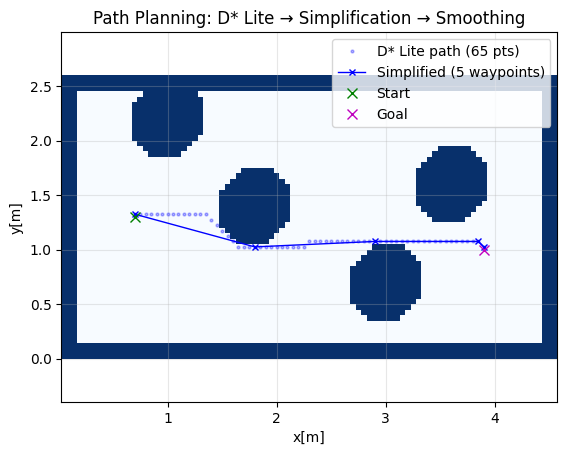

In [2]:
grid_map = create_test_environment()
# Plan
start = (0.7, 1.3)
goal = (3.9, 1.0)
path_found, pathx, pathy = plan_path(grid_map, start, goal)

# Simplify
pathx_simp, pathy_simp = simplify_path(pathx, pathy, grid_map)

# Convert to world coords
pos_x, pos_y = grid_map.get_xy_poss_from_xy_indexes(pathx_simp, pathy_simp)


visualize_path(grid_map, start_pos=start, goal_pos=goal, show_smooth=False);

In [3]:
def set_initial_position(cf, x, y, z, yaw_deg):
    cf.param.set_value('kalman.initialX', x)
    cf.param.set_value('kalman.initialY', y)
    cf.param.set_value('kalman.initialZ', z)

    yaw_radians = math.radians(yaw_deg)
    cf.param.set_value('kalman.initialYaw', yaw_radians)

In [ ]:
controller = CrazyflieController(enable_plotting=False)
config = controller.config
# Initialize drivers
cflib.crtp.init_drivers()
print("✅ Drivers initialized"  )
# Connect to Crazyflie (will auto-detect or use config URI)
uri = config['connection']['uri']
time.sleep(0.5)
controller.connect(uri, x=start[0], y=start[1], z=0.1, yaw=0.0)
print("✅ Connection initiated"  )
# Wait for connection
if controller.wait_for_connection(timeout=10.0):
    logger.info("✅ Connected successfully!")
else:
    logger.error("❌ Connection failed!")
    raise Exception("Could not connect to Crazyflie")


try:
    mission_time = 10.0  # seconds - increased timeout for waypoint following
    start_time = time.time()
    
    # set_initial_position(cf=controller.cf, x=start[0], y=start[1], z=0.1, yaw_deg=0.0)
    # Setup position commander
    pc = PositionHlCommander(
        crazyflie=controller.cf,
        x=start[0],
        y=start[1],
        z=0.1,
        default_velocity=0.2,
        default_height=0.5,
        controller=2
    )
        
    # Start multiranger for obstacle detection
    multiranger = Multiranger(controller.cf)
    multiranger.start()
    logger.info("✅ Multiranger started")
    
    # Takeoff
    logger.info("🚁 Taking off...")
    height = 0.5
    pc.take_off(height=height, velocity=0.5)
    time.sleep(2)  # Wait for stable takeoff

    # Follow waypoints
    logger.info(f"🗺️ Following {len(pos_x)} waypoints...")

    latest = controller.get_latest_data()
    current_x = latest.get('stateEstimate.x', 0)
    current_y = latest.get('stateEstimate.y', 0)
    current_z = latest.get('stateEstimate.z', 0)

    logger.info(f"📍 Current position: ({current_x:.2f}, {current_y:.2f}, {current_z:.2f})")

    logger.info("🛬 Landing...")
    pc.land()
    
    # Monitor landing
    current_time = time.time()
    while time.time() - current_time < 3:
        latest = controller.get_latest_data()
        logger.info(f"📍 Landing position: ({latest.get('stateEstimate.x', 0):.2f}, "
                   f"{latest.get('stateEstimate.y', 0):.2f}, {latest.get('stateEstimate.z', 0):.2f})")
        time.sleep(0.1) 
    
    # Stop multiranger
    multiranger.stop()
    controller.save_flight_data()
    logger.info("✅ Waypoint following complete!")
    
except Exception as e:
    logger.error(f"❌ Error during flight: {e}")
    try:
        pc.land()
    except:
        pass
    controller.emergency_shutdown()
    raise
finally:
    controller.cleanup()
    controller.disconnect()

    

2025-10-05 22:11:45,428 - cfpilot.detection - INFO - Landing pad detector initialized
2025-10-05 22:11:45,429 - cfpilot.controller - INFO - Crazyflie Controller initialized (Async)


✅ Drivers initialized


2025-10-05 22:11:45,930 - cfpilot.controller - INFO - Connecting to radio://0/88/2M/E7E7E7E7F0
2025-10-05 22:11:45,930 - cflib.crazyflie - INFO - Callback->Connection initialized[radio://0/88/2M/E7E7E7E7F0]
2025-10-05 22:11:46,216 - cflib.crazyflie - INFO - We are connected[radio://0/88/2M/E7E7E7E7F0], request connection setup
2025-10-05 22:11:46,217 - cflib.crazyflie.platformservice - INFO - Request _request_protocol_version()
2025-10-05 22:11:46,574 - cflib.crazyflie - WARNING - Got link error callback [Too many packets lost] in state [1]
2025-10-05 22:11:46,575 - cflib.crazyflie - INFO - Callback->Connected failed to [radio://0/88/2M/E7E7E7E7F0]: Too many packets lost
2025-10-05 22:11:46,576 - cfpilot.controller - ERROR - ❌ Connection to radio://0/88/2M/E7E7E7E7F0 failed: Too many packets lost
2025-10-05 22:11:51,900 - cfpilot.controller - WARNING - Signal 2 received - initiating emergency shutdown
2025-10-05 22:11:51,901 - cfpilot.controller - WARNING - ❌ Emergency shutdown initiat

In [ ]:
controller = CrazyflieController(enable_plotting=False)
config = controller.config
# Initialize drivers
cflib.crtp.init_drivers()

# Connect to Crazyflie (will auto-detect or use config URI)
uri = config['connection']['uri']
controller.connect(uri)

# Wait for connection
if controller.wait_for_connection(timeout=10.0):
    logger.info("✅ Connected successfully!")
else:
    logger.error("❌ Connection failed!")
    raise Exception("Could not connect to Crazyflie")

try:
    mission_time = 60.0  # seconds - increased timeout for waypoint following
    start_time = time.time()
    
    # Setup position commander
    pc = PositionHlCommander(
        crazyflie=controller.cf,
        x=start[0],
        y=start[1],
        z=0.1,
        default_velocity=0.2,
        default_height=0.5,
        controller=2
    )
    
    # Start multiranger for obstacle detection
    multiranger = Multiranger(controller.cf)
    multiranger.start()
    logger.info("✅ Multiranger started")
    
    # Takeoff
    logger.info("🚁 Taking off...")
    height = 0.5
    pc.take_off(height=height, velocity=0.5)
    time.sleep(2)  # Wait for stable takeoff

    # Follow waypoints
    logger.info(f"🗺️ Following {len(pos_x)} waypoints...")
    
    for i, (target_x, target_y) in enumerate(zip(pos_x, pos_y)):
        if time.time() - start_time > mission_time:
            logger.warning("⏰ Mission timeout reached")
            break
            
        logger.info(f"🎯 Waypoint {i+1}/{len(pos_x)}: ({target_x:.2f}, {target_y:.2f})")
        
        # Move to waypoint
        pc.go_to(target_x, target_y, height, velocity=0.3)
        
        # Wait and verify position
        time.sleep(0.5)
        latest = controller.get_latest_data()
        current_x = latest.get('stateEstimate.x', 0)
        current_y = latest.get('stateEstimate.y', 0)
        current_z = latest.get('stateEstimate.z', 0)
        
        # Calculate distance to target
        distance = ((current_x - target_x)**2 + (current_y - target_y)**2)**0.5
        
        logger.info(f"📍 Current position: ({current_x:.2f}, {current_y:.2f}, {current_z:.2f})")
        logger.info(f"📏 Distance to waypoint: {distance:.2f}m")
        
        # Fine adjustment if needed
        max_attempts = 1
        attempt = 0
        while distance > 0.2 and attempt < max_attempts and time.time() - start_time < mission_time:
            logger.info(f"🔧 Fine adjustment attempt {attempt+1}")
            pc.go_to(target_x, target_y, height, velocity=0.1)
            time.sleep(0.5)
            
            latest = controller.get_latest_data()
            current_x = latest.get('stateEstimate.x', 0)
            current_y = latest.get('stateEstimate.y', 0)
            distance = ((current_x - target_x)**2 + (current_y - target_y)**2)**0.5
            attempt += 1
        
        logger.info(f"✅ Waypoint {i+1} reached (distance: {distance:.2f}m)")

    # Final position check
    latest = controller.get_latest_data()
    final_x = latest.get('stateEstimate.x', 0)
    final_y = latest.get('stateEstimate.y', 0)
    final_z = latest.get('stateEstimate.z', 0)
    logger.info(f"📍 Final position before landing: ({final_x:.2f}, {final_y:.2f}, {final_z:.2f})")

    # Land
    logger.info("🛬 Landing...")
    pc.land()
    
    # Monitor landing
    current_time = time.time()
    while time.time() - current_time < 3:
        latest = controller.get_latest_data()
        logger.info(f"📍 Landing position: ({latest.get('stateEstimate.x', 0):.2f}, "
                   f"{latest.get('stateEstimate.y', 0):.2f}, {latest.get('stateEstimate.z', 0):.2f})")
        time.sleep(0.5) 
    
    # Stop multiranger
    multiranger.stop()
    controller.save_flight_data()
    logger.info("✅ Waypoint following complete!")
    
except Exception as e:
    logger.error(f"❌ Error during flight: {e}")
    try:
        pc.land()
    except:
        pass
    controller.emergency_shutdown()
    raise
finally:
    controller.cleanup()
    controller.disconnect()
